In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '..'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images

def pca_zm_proj(X, K=None):
    """return PCA projection matrix for zero mean data

    Inputs:
        X N,D design matrix of input features -- must be zero mean
        K     how many columns to return in projection matrix

    Outputs:
        V D,K matrix to apply to X or other matrices shifted in same way.
    """
    if np.max(np.abs(np.mean(X,0))) > 1e-3:
        raise ValueError('Data is not zero mean.')
    if K is None:
        K = X.shape[1]
    E, V = np.linalg.eigh(np.dot(X.T, X))
    idx = np.argsort(E)[::-1]
    V = V[:, idx[:K]] # D,K
    return V

## Get data

In [2]:
img_size = 28

train_data = SandiaDataProvider(which_set='train', dataset_home='../../datasets/sandia/', img_size=28)
test_data = SandiaDataProvider(which_set='test', dataset_home='../../datasets/sandia/', img_size=28)

# These are in the shape <num_questions, imsize, imsize, 16(8Q + 8A)> - transpose and reshape so that they are
# in the shape <num_images, img_size **2 >
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
X_test = test_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)

Check that we're reshaping the data correctly - we should have the images as row vectors

In [3]:
train_data.inputs.shape

(756, 28, 28, 16)

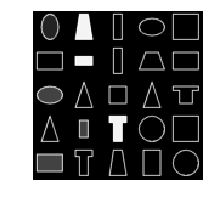

In [5]:
fig = plt.figure(figsize=(3,3))
show_batch_of_images(X[:25].reshape(25, img_size, img_size), fig);

## Center data

In [6]:
mu = np.mean(X, axis=0)
X_centered = X - mu

## Obtain projection matrix

In [7]:
V = pca_zm_proj(X_centered)
print(V.shape)

(784, 784)


## Plot projection onto first two principal components

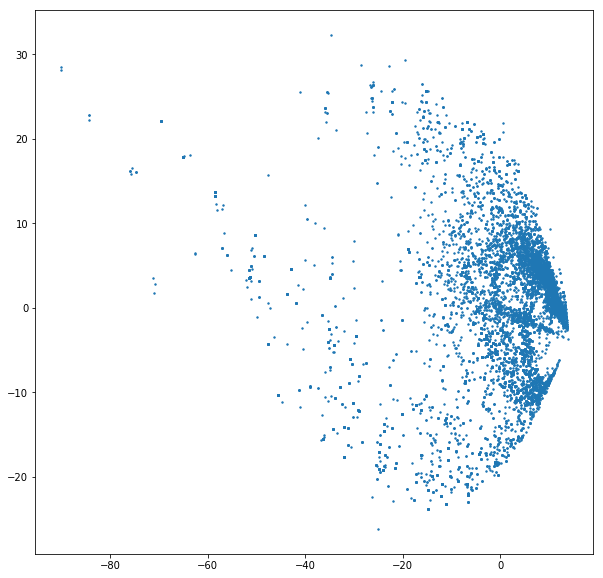

In [8]:
X2d = X_centered @ V[:, :2]

plt.figure(figsize=(10, 10))
plt.scatter(X2d[:, 0], X2d[:, 1], s=2);

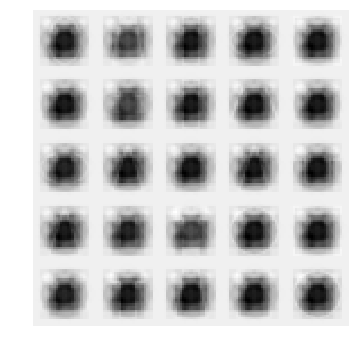

In [9]:
comp = 0

X_proj = X_centered @ V
X_rec = X_proj @ V.T + mu

std = np.std(X_proj[:, comp])
X_pert = X_centered @ V
X_pert[:, comp] += 25 * std

X_rec1 = X_pert @ V.T + mu

show_batch_of_images(X_rec1[:25].reshape(-1, img_size, img_size), plt.figure(figsize=(5,5)));

# Do the same thing with our class

In [10]:
from src.autoencoders import PCA_autoencoder

enc = PCA_autoencoder()
enc.train(X)

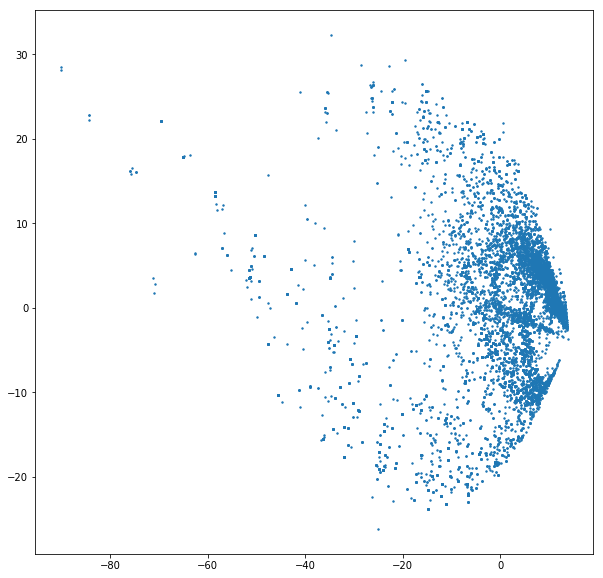

In [11]:
X2d = enc.encode(X, 2)

plt.figure(figsize=(10, 10))
plt.scatter(X2d[:, 0], X2d[:, 1], s=2);

## Make sure decoding works on training data

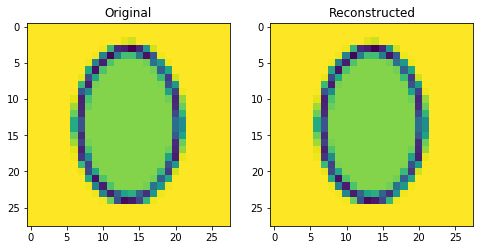

In [12]:
X_enc = enc.encode(X, img_size ** 2)
X_dec = enc.decode(X_enc)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(X[0].reshape(img_size, img_size))
axs[0].set_title('Original')
axs[1].imshow(X_dec[0].reshape(img_size, img_size));
axs[1].set_title('Reconstructed');

# Try encoding test data

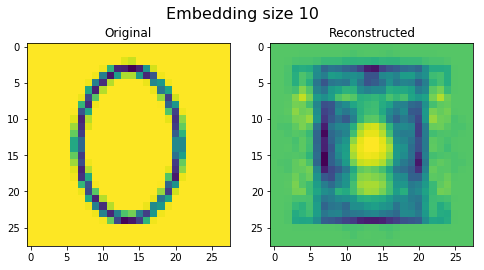

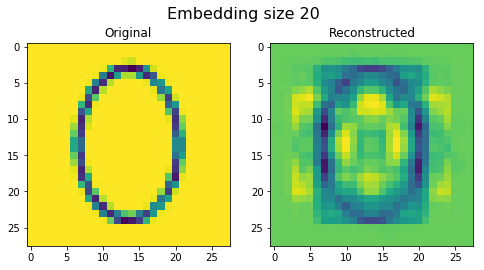

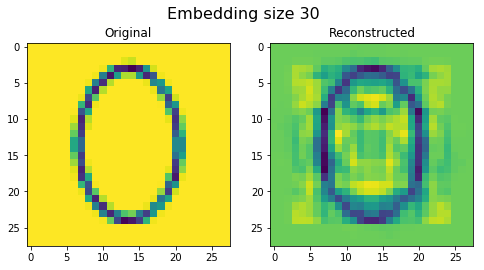

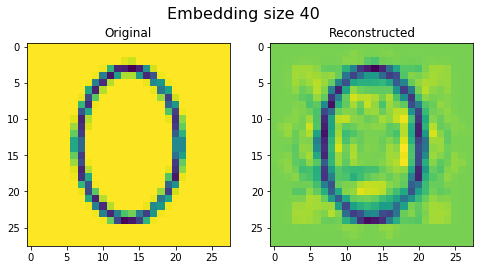

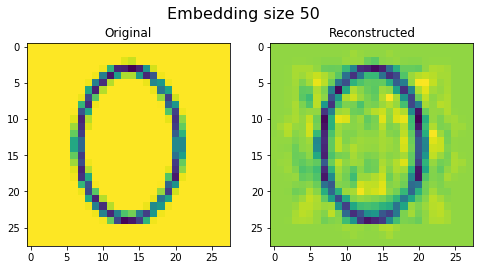

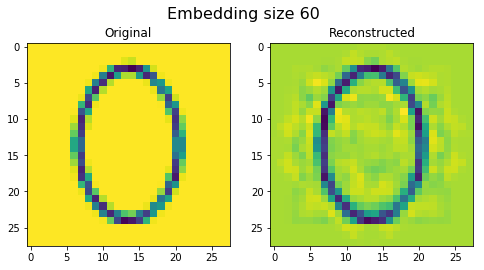

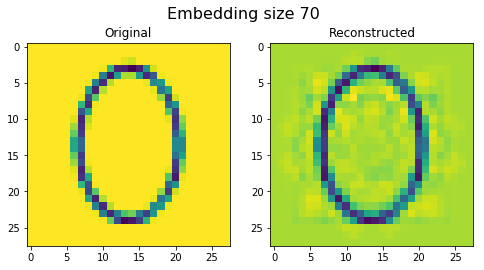

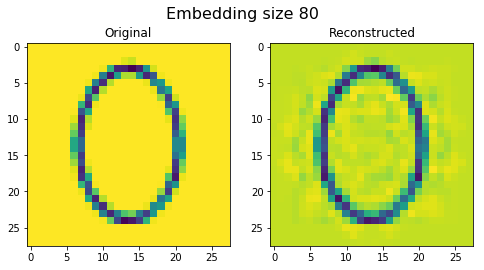

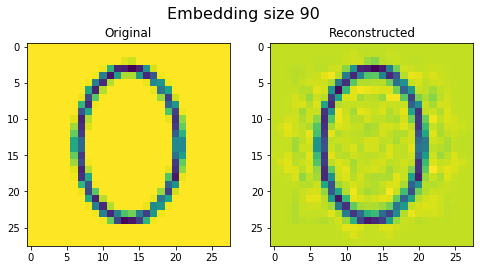

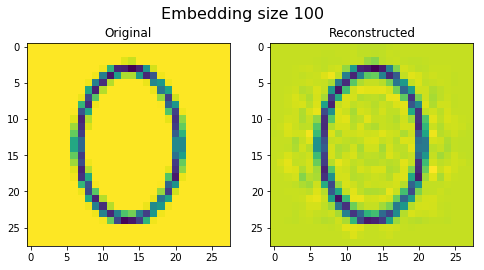

In [13]:
img_id = 18
for emb_size in range(10, 110, 10):
    test_enc = enc.encode(X_test, emb_size)
    test_dec = enc.decode(test_enc)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.suptitle(f'Embedding size {emb_size}', fontsize=16)
    axs[0].imshow(X_test[img_id].reshape(img_size, img_size))
    axs[0].set_title('Original')
    axs[1].imshow(test_dec[img_id].reshape(img_size, img_size));
    axs[1].set_title('Reconstructed');

## Measure MSE on test data

CPU times: user 37.4 s, sys: 3.22 s, total: 40.6 s
Wall time: 10.2 s


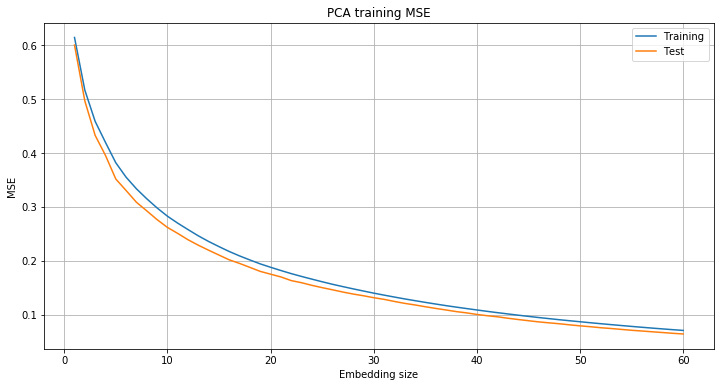

In [29]:
%%time
sizes = []
train_losses = []
test_losses = []
for emb_size in range(1, 61):
    test_enc = enc.encode(X_test, emb_size)
    test_dec = enc.decode(test_enc)
    
    train_enc = enc.encode(X, emb_size)
    train_dec = enc.decode(train_enc)
    
    sizes.append(emb_size)
    test_losses.append(np.mean((X_test - test_dec) ** 2))
    train_losses.append(np.mean((X - train_dec) ** 2))
    
plt.figure(figsize=(12, 6))
plt.title('PCA training MSE')
plt.xlabel('Embedding size')
plt.ylabel('MSE')
plt.grid()
plt.plot(sizes, train_losses, label='Training');
plt.plot(sizes, test_losses, label='Test');
plt.legend();